In [ ]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import seaborn as sns
import string
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import re
!pip install emoji
import emoji
from random import randbytes

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data loading

In [ ]:
!wget https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/test.csv
!wget https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/train.csv
!wget https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/test_labels.csv

--2023-03-28 18:37:06--  https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60354593 (58M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]  57.56M   186MB/s    in 0.3s    

2023-03-28 18:37:07 (186 MB/s) - ‘test.csv.1’ saved [60354593/60354593]

--2023-03-28 18:37:07--  https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting r

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.shape

(159571, 8)

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test.shape

(153164, 2)

In [ ]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test_labels.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data exploration

In [ ]:
test[test['comment_text'].str.contains('img')].iloc[1, 1]

'Monster here taken form the toys being produced to market for the film. \n\n [img]http://64.111.216.18/ul/5641-clover.jpg[/img]'

In [ ]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' % 
          (perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])
        
check_null(train, train.columns)

0% or 0 missing from id column.
0% or 0 missing from comment_text column.
0% or 0 missing from toxic column.
0% or 0 missing from severe_toxic column.
0% or 0 missing from obscene column.
0% or 0 missing from threat column.
0% or 0 missing from insult column.
0% or 0 missing from identity_hate column.


<Axes: title={'center': 'Labels Frequency'}>

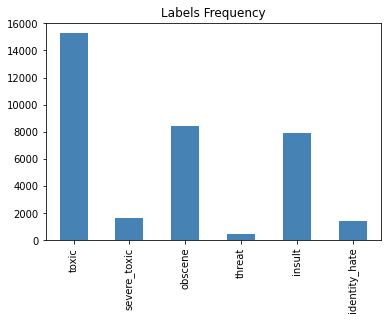

In [ ]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

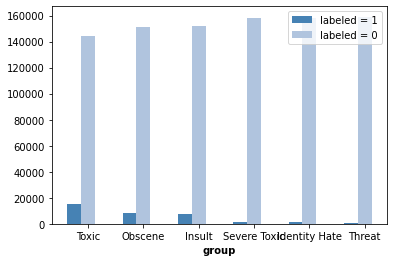

In [ ]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

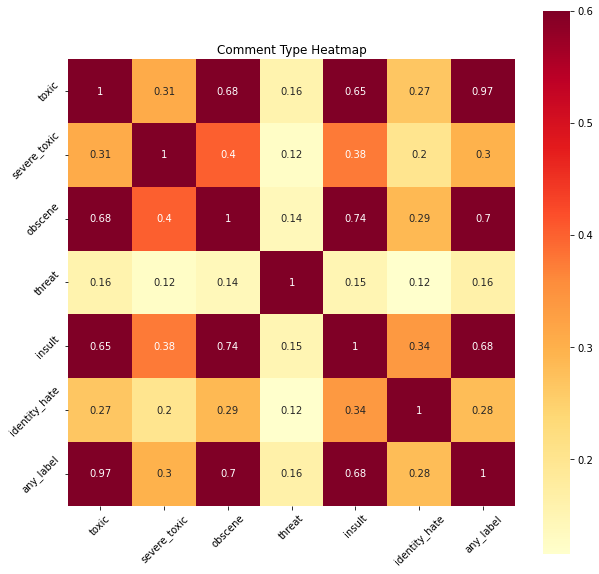

In [ ]:
targets = list(train.columns[2:])
df_targets = train[targets].copy()

# How many rows are toxic? 
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

# Create overall any_label feature
targets.append('any_label')
df_targets['any_label'] = toxic_rows

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts


del(df_selection)

def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Comment Type Heatmap')

### Data preprocessing

1. Lower case
2. Remove ips and tokenize links(possibly)
3. Remove numbers
4. Delete punctuation(except '')

To search:

1. Smiles to words mapping
2. Abbreviations
3. Grammar checks
4. Lemmatization(bad words to one unique form)
5. Remove images

##### Basics

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 28.4 MB/s eta 0:00:00


In [ ]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import sys

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def cap2word(text):
    delimiter = str(randbytes(100))
    def apply_delimiter(match):
        match = str(match.group())
        match = match[0] + match[-1]
        return match.lower() + delimiter

    spaces = re.sub(r'[A-Z] [A-Z]', apply_delimiter, text)
    return spaces.replace(delimiter+' ', '', spaces.count(delimiter)-1).replace(delimiter, '')

def remove_img(sample):
    """Remove images from a sample string"""
    return re.sub(r"\[img\]\S+\[/img\]", ' ', sample)

def strip_ip(s):
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    try:
        found = ip.search(s)
        return s.replace(found.group(), ' ')
    except:
        return s

def replace_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"(https://)([.\w]+)(/\S+)", r"\2", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    return [word.encode('ascii', 'ignore').decode('ascii') for word in words]

def to_lowercase(text):
    """Convert all characters to lowercase in string of text"""
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from string of text"""
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    return nopunct

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_img(sample)
    sample = replace_URL(sample)
    sample = emoji.demojize(sample)
    sample = strip_ip(sample)
    sample = remove_img(sample)
    sample = cap2word(sample)
    sample = replace_contractions(sample)
    sample = sample.lower()
    sample = remove_punctuation(sample)
    
    words = nltk.word_tokenize(sample)
    return normalize(words)



In [ ]:
pipe = lambda x: normalize(preprocess(x))

In [ ]:
pipe("S O M E thing S H I T  kjfdnvabfnDFJ P948 F84 0149Y4 84 MCNAHDBJDHJDSD shit piss fuck cunt cocksucker motherfucker tits 👆🤡😱")

['something',
 'shit',
 'kjfdnvabfndfjp',
 'f',
 'mcnahdbjdhjdsd',
 'shit',
 'piss',
 'fuck',
 'cunt',
 'cocksucker',
 'motherfucker',
 'tits',
 'backhand',
 'index',
 'pointing',
 'clown',
 'face',
 'face',
 'screaming',
 'fear']

In [ ]:
train['comment_text'] = train['comment_text'].apply(pipe)
train

KeyboardInterrupt: ignored